# Overview

This file is used to investigate the following questions:

- How many discrete-variable columns are there? For each such column, how many discrete variables are there?
- How many possible pairs can be formed from the numerical variables?
- How many combinations at most can be generated using one-hot encoding?
- For each one-hot encoding combination, how large is the sample size?

# Imports

In [10]:
# Third-party modules
from IPython.display import display, HTML
from math import log
import csv
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pylab
import math
import random
import scipy.stats as ss
from pprint import pprint

# Custom modules
from common.localio import *
from common.summary import *

# Datasets

Load each dataset and display the first few entries.

In [11]:
# Load the entire dataset

hist = CSVReader('../datasets/historical_transactions.csv', datetime_cols = ['purchase_date'])
merch = CSVReader('../datasets/merchants.csv')
new_merch = CSVReader('../datasets/new_merchant_transactions.csv', datetime_cols = ['purchase_date'])
train = CSVReader('../datasets/train.csv')
test = CSVReader('../datasets/test.csv')

# Functions

In [18]:
def get_unique_counts(df, column_names):
    
    df = df[column_names]
    
    output = {}
    
    for column_name in column_names:
        output[column_name] = len(pd.unique(df[column_name]))
        
    return output

In [13]:
def prod(iterable):
    output = 1
    for each in iterable:
        output *= each
    return output

# Analysis

Count the number of unique values in each categorical column (ie. dimension).

As a conservative estimate, the anonymized categories in transaction histories and merchant-level data are assumed to  represent different meaning.

In [19]:
categorical_counts = {
'hist_and_new_merch': get_unique_counts(
    pd.concat([hist.data, new_merch.data]), 
    ['authorized_flag', 'category_1', 'category_2', 'category_3',]),
'merch': get_unique_counts(
    merch.data, 
    ['merchant_group_id', 'category_1', 'category_2', 'category_4', 
    'most_recent_sales_range', 'most_recent_purchases_range']),
'train_and_test': get_unique_counts(
    pd.concat([train.data, test.data]), 
    ['feature_1', 'feature_2', 'feature_3']),
'_shared': get_unique_counts(
    pd.concat([hist.data, new_merch.data, merch.data]),
    ['city_id', 'merchant_category_id', 'state_id', 'subsector_id']
    )
}

Display:

In [21]:
pprint(categorical_counts)

{'_shared': {'city_id': 308,
             'merchant_category_id': 333,
             'state_id': 25,
             'subsector_id': 41},
 'hist_and_new_merch': {'authorized_flag': 2,
                        'category_1': 2,
                        'category_2': 6,
                        'category_3': 4},
 'merch': {'category_1': 2,
           'category_2': 6,
           'category_4': 2,
           'merchant_group_id': 109391,
           'most_recent_purchases_range': 5,
           'most_recent_sales_range': 5},
 'train_and_test': {'feature_1': 5, 'feature_2': 3, 'feature_3': 2}}


Total number of variations available is

In [22]:
total_vars = prod(prod(sub_dict.values()) for sub_dict in categorical_counts.values())
print(total_vars)

19872117481708800000


which is too large for the dataset. Even if merchant_group_id is not considered, the number of all possible variations remains large still:

In [23]:
print(round(total_vars / categorical_counts['merch']['merchant_group_id']))

181661356800000


It may therefore be helpful to identify clusters of data points and simplify the dataset a bit.

- Identify which specific combinations tend to appear. Combinations (or groups of combinations) that tend to appear most frequently can be placed in the same cluster. All other combinations that may appear in principle but that are rarely observed or not at all observed can then be placed in an "everything else" cluster.

- Or, use clustering technique to separate data points in terms of how similar or different their loyalty score behaviours are. This is more direct than the previous approach.

# Sub-distributions

We plot the target variable distribution by the categorical variables. It appears that they are all similarly distributed, so we may expect them to provide very little additional predictive power.

In [204]:
def plot_distribution_by_groups(df, by, column, max_plots_horizontal = 5, **kwargs):
    count_unique = len(pd.unique(df[by]))
    train.data.hist(by = by, 
                    column = column, 
                    layout = (math.ceil(count_unique / max_plots_horizontal), 
                              min(count_unique, max_plots_horizontal)),
                   **kwargs)
    plt.show()

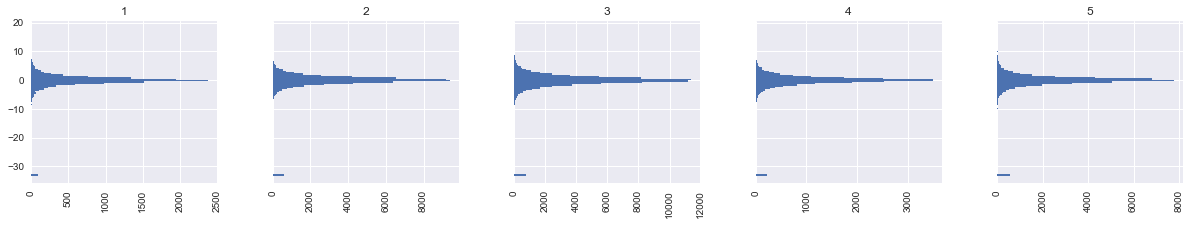

In [205]:
plot_distribution_by_groups(train.data, 'feature_1', 'target', 
                            bins = 100, sharey = True, figsize = (20,3), orientation = "horizontal")

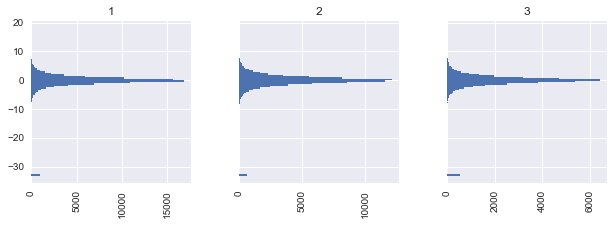

In [207]:
plot_distribution_by_groups(train.data, 'feature_2', 'target', 
                            bins = 100, sharey = True, figsize = (10,3), orientation = "horizontal")

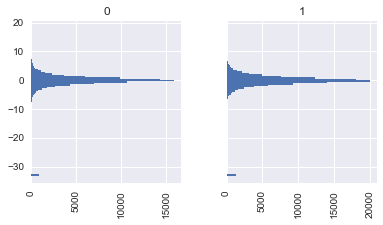

In [209]:
plot_distribution_by_groups(train.data, 'feature_3', 'target', 
                            bins = 100, sharey = True, figsize = (6,3), orientation = "horizontal")

Even forming combinations of the features does not seem to help.

In [184]:
train.data['feature_1_2'] = train.data[['feature_1', 'feature_2']].apply(lambda x: tuple(x), axis = 1)
train.data['feature_1_3'] = train.data[['feature_1', 'feature_3']].apply(lambda x: tuple(x), axis = 1)
train.data['feature_2_3'] = train.data[['feature_2', 'feature_3']].apply(lambda x: tuple(x), axis = 1)
train.data['feature_1_2_3'] = train.data[['feature_1', 'feature_2', 'feature_3']].apply(lambda x: tuple(x), axis = 1)

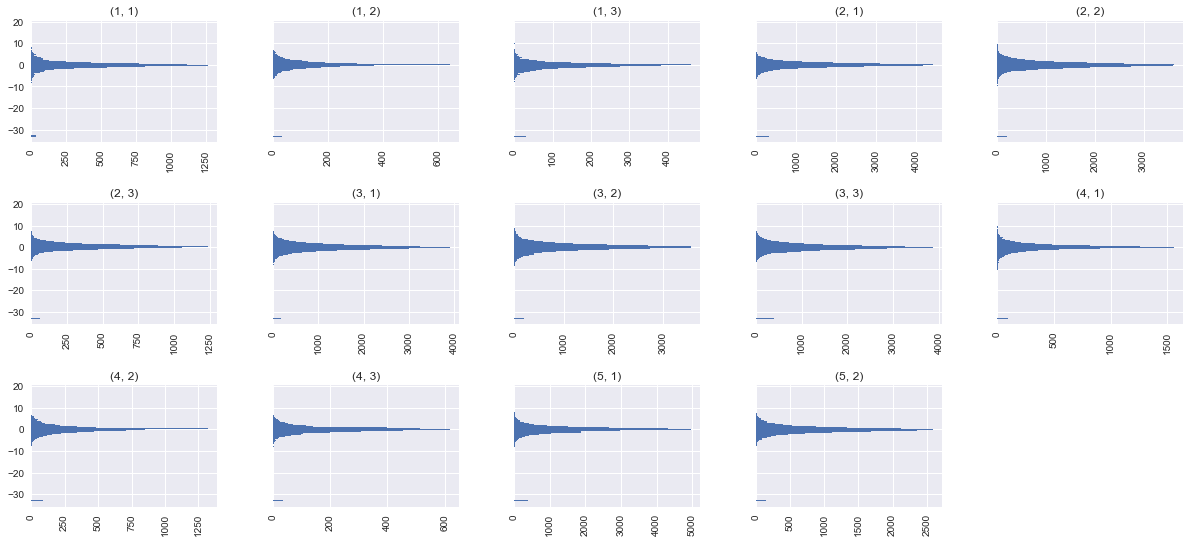

In [221]:
plot_distribution_by_groups(train.data, 'feature_1_2', 'target', 
                            bins = 100, sharey = True, figsize = (20,9), orientation = "horizontal")

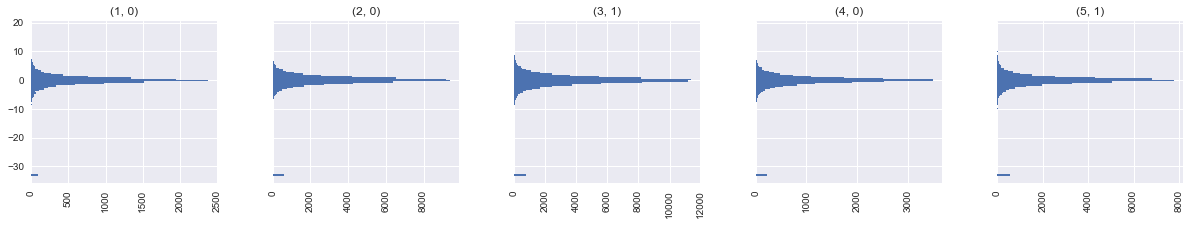

In [217]:
plot_distribution_by_groups(train.data, 'feature_1_3', 'target', 
                            bins = 100, sharey = True, figsize = (20, 3), orientation = "horizontal")

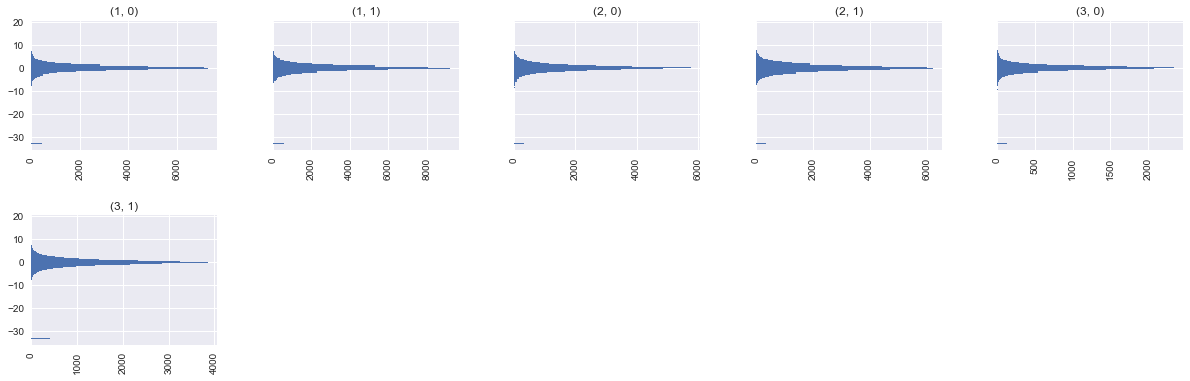

In [220]:
plot_distribution_by_groups(train.data, 'feature_2_3', 'target', 
                            bins = 100, sharey = True, figsize = (20,6), orientation = "horizontal")

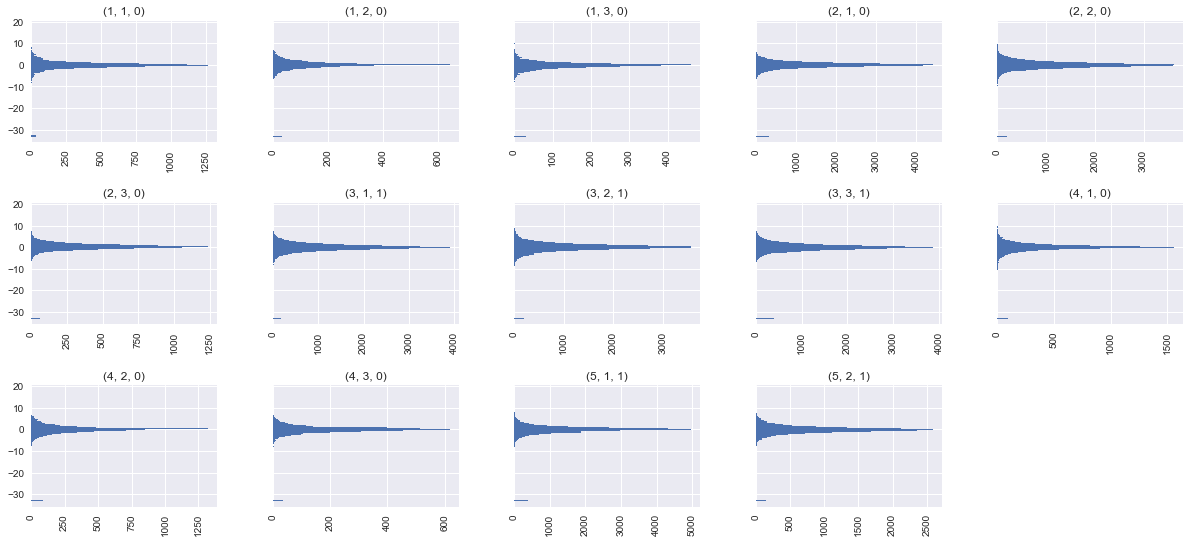

In [222]:
plot_distribution_by_groups(train.data, 'feature_1_2_3', 'target', 
                            bins = 100, sharey = True, figsize = (20,9), orientation = "horizontal")